In [1]:
from asymptotic_complexity_analysis import *
import numpy as np
import datetime, os

log_dir = "./results/complexity"
for i in range(1, 100):
    proposed_dir = f"./results/complexity_{i}"
    if not os.path.exists(proposed_dir):
        log_dir = proposed_dir
        os.makedirs(log_dir)
        break
timestamp = datetime.datetime.now().strftime("%m%d_%H%M")

In [2]:
from bart_playground.bandit.sim_util import LinearScenario, LinearOffsetScenario, OffsetScenario, FriedmanScenario

n_simulations = 8 
n_draws = 600 

print("Step 1: Creating scenarios...")

# Set a fixed seed for reproducibility
np.random.seed(42)

# Create scenarios
n_arms = 3
n_features = 5
sigma2 = 1.0

scenarios = {
    # 'Linear': LinearScenario(P=n_features, K=n_arms, sigma2=sigma2),
    # 'LinearOffset': LinearOffsetScenario(P=n_features, K=n_arms, sigma2=sigma2),
    'Offset': OffsetScenario(P=n_features, K=n_arms, sigma2=sigma2, lambda_val=1)
    # 'Friedman': FriedmanScenario(P=n_features, K=n_arms, sigma2=sigma2, lambda_val=8)
}

Step 1: Creating scenarios...


In [3]:
print("Step 2: Generating simulation data...")
all_scenarios_regrets = generate_simulation_data(scenarios, n_simulations, n_draws)

Step 2: Generating simulation data...

Generating data for Offset scenario...


Simulating: 100%|██████████| 8/8 [08:06<00:00, 60.87s/it]



Step 3: Computing pointwise averages...


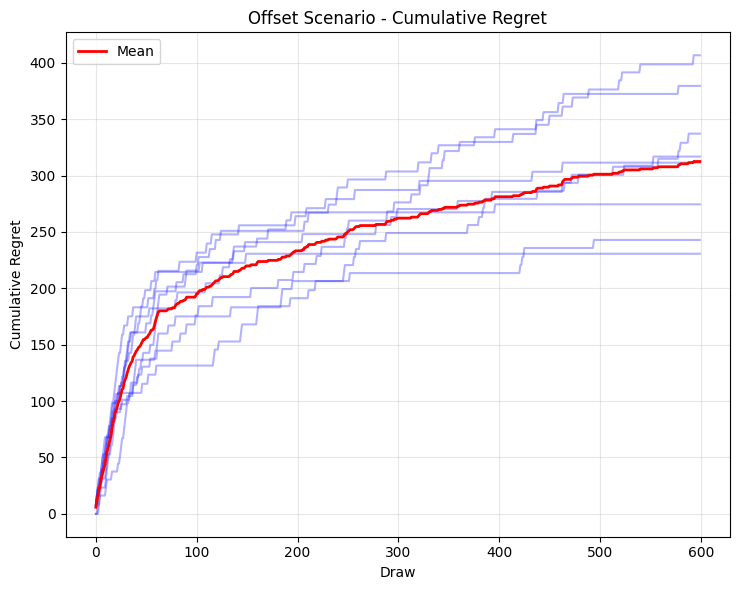

In [4]:
print("\nStep 3: Computing pointwise averages...")
scenario_means = {name: compute_pointwise_average(regrets) for name, regrets in all_scenarios_regrets.items()}

# Plot the raw results
raw_save_path = os.path.join(log_dir, f"regret_curves_raw_{timestamp}.png")
plot_scenario_results(all_scenarios_regrets, scenario_means, n_simulations, raw_save_path)

In [5]:
print("\nStep 4: Smoothing and analyzing asymptotic complexity...")
# Define number of points to use for asymptotic analysis
min_points = (2.0/3 * n_draws)  # 2/3 of the total draws
# convert to int
min_points = int(min_points)

complexity_results = analyze_asymptotic_complexity(
    all_scenarios_regrets, 
    scenario_means,
    smoothing_method='gaussian',
    growth_model='both',
    plot=False,
    min_points=min_points
)


Step 4: Smoothing and analyzing asymptotic complexity...

Analyzing asymptotic complexity for Offset scenario...



Step 5: Creating visualization of asymptotic complexity analysis...


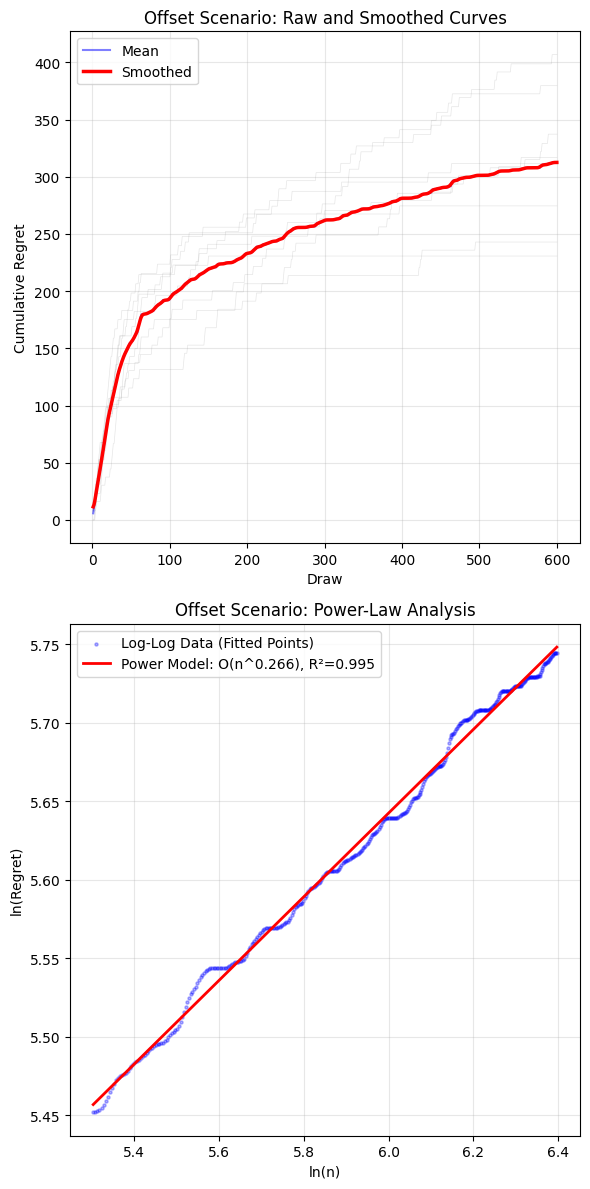

In [6]:
# Step 5: Visualization with smoothing and regression analysis
print("\nStep 5: Creating visualization of asymptotic complexity analysis...")
complexity_viz_path = os.path.join(log_dir, f"complexity_analysis_{timestamp}.png")
plot_complexity_analysis(
    complexity_results,
    all_scenarios_regrets,
    scenario_means,
    n_simulations,
    save_path=complexity_viz_path,
    min_points=min_points
)

In [7]:
print("\nAnalysis complete!")

log_filename = os.path.join(log_dir, f"analysis_summary_{timestamp}.txt")
with open(log_filename, 'w') as log_file:
    for scenario, result in complexity_results.items():
        growth = result['growth_results']
        best_model = growth.get('best_model', 'Unknown')
    
        log_file.write(f"\n{scenario} Scenario:")
        log_file.write(f"  - Best fitting model: {best_model}")

        # Power-law model
        power_model = growth.get('power', {})
        if power_model:
            log_file.write(f"\n  - Power-law model:")
            log_file.write(f"\n    * Complexity: {power_model.get('big_o', 'Unknown')}")
            log_file.write(f"\n    * Exponent: {power_model.get('exponent', 'N/A'):.4f}")
            log_file.write(f"\n    * R-squared: {power_model.get('r_squared', 'N/A'):.4f}")
            log_file.write(f"\n    * AIC: {power_model.get('aic', 'N/A'):.4f}")

        # Logarithmic model
        log_model = growth.get('log', {})
        if log_model:
            log_file.write(f"\n  - Logarithmic model:")
            log_file.write(f"\n    * Complexity: {log_model.get('big_o', 'Unknown')}")
            log_file.write(f"\n    * Slope: {log_model.get('slope', 'N/A'):.4f}")
            log_file.write(f"\n    * R-squared: {log_model.get('r_squared', 'N/A'):.4f}")
            log_file.write(f"\n    * AIC: {log_model.get('aic', 'N/A'):.4f}")


Analysis complete!


In [8]:
import pickle

result_filename = os.path.join(log_dir, f"result_{timestamp}.pkl")
with open(result_filename, "wb") as file:
    pickle.dump((all_scenarios_regrets, scenario_means, complexity_results), file)